# The Preface

In [34]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.neighbors import kneighbors_graph

import networkx as nx
import pickle

from scipy.sparse.linalg import eigs

In [18]:
votes = pd.read_csv("../generated/votes.csv.gz")
members = pd.read_csv("../generated/members.csv")
full_votes = pd.read_csv("../generated/full_votes.csv.gz")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Missing values**<br>
Impute missing values with the mean along the rows. Reasoning: If a parlamentarian didn't participate in the vote, we want him to be as neutral as possible, such that he isn't defined by votes he didn't participate in.

In [19]:
yesno = votes.iloc[:,1:].copy()
yesno[yesno>1] = np.NaN
yesno[yesno<0] = np.NaN

In [20]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
yesno_imp = imp.fit_transform(yesno.T).T

# 1. Politician Representations
In the following section, we create different representations for the politicians. In particular, we reduce their voting behavior down to its principal components, explore the manifold of politicians using TSNE and create a nearest-neighbor graph of politicians. We will then reuse the different representations of politicians in order to validate the results of our analysis.

## 1.1 Global PCA
We start off by reducing the politician votes to its principal components using principal component analysis (PCA) of the entire dataset. 

In [21]:
def do_pca(data, explained_var=.75, return_fits=True):
    """
    Rescales variables to have mean zero, then performs PCA.
    
    Parameters
    ----------
    data:
        Data to transform. Rows are observations, columns are features
    explained_var:
        Retains enough principal components to explain "explained_var" percent
        of the total variance
    return_fits:
        If true, returns the rescale fit and the pca fit together with the principal components.
        Otherwise returns only principal components.
    """
    
    # Fit scaler and PCA
    scalefit = StandardScaler(with_std=False).fit(data)
    scaled = scalefit.transform(data)
    pcafit = PCA().fit(scaled)
    
    # Get nb pcs to retain
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    nb_retain = np.where(expl_var>.75)[0][0]
    
    # Project onto PCs
    pc = pcafit.transform(scaled)[:,:nb_retain]
    
    if return_fits:
        return pc, scalefit, pcafit
    else:
        return pc

pc, scalefit, pcafit = do_pca(yesno_imp.T)

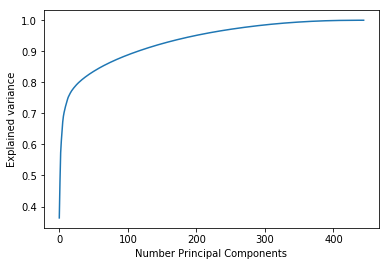

In [22]:
def explained_variance_plot(pcafit):
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    plt.plot(expl_var)
    plt.ylabel("Explained variance")
    plt.xlabel("Number Principal Components")

explained_variance_plot(pcafit)
plt.show()

Very few principal components seem to explain 75% of the data variance already. We thus retain only those principal components for the future analysis.

#### Validation of PCA

*Vote Importance Score*<br>
From the PCA, we can construct an importance score for every individual vote: We do so by determining how much each vote contributes to the most important principal components. A high score means that a vote is very important for determining the politician's general location in the reduced space. We can thus validate the quality of our PCA by looking at the most- and least important votes and determine whether they make sense from a politological point of view.

In [23]:
def vote_importance_score(pc, pcafit):
    """
    Determines vote importance as the summed contribution of the vote to the retained 
    principal components.
    """
    nb_retain = pc.shape[1]
    return np.abs(pcafit.components_[:nb_retain,:]).sum(axis=0)

vote_importance = vote_importance_score(pc, pcafit)

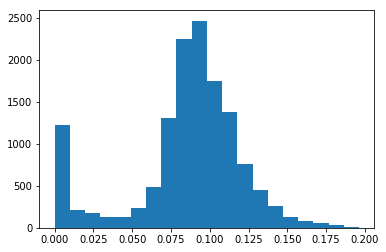

In [24]:
plt.hist(vote_importance, bins=20)
plt.show()

> TODO: Look at the outliers in both directions, see whether they make sense. If yes: Good pca, if not: Bad PCA

*Interpretation of the principal direction*<br>
Another way to validate the PCA is to see whether we can find an interpretation of the principal directions. To this effect, we correlate the principal component scores of the politicians with other attributes known about them, such as their age, gender, number of votes they participated in, etc.

> Moreover it would be interesting to correlate the principal components with other interesting variables about the politicians, such as gender, age, legislature or language, to see whether our principal components have a real-life interpretation.

## 1.2 Non-linear Embedding in 2D with t-SNE

Using the principal component analysis, we embedded the data into a lower-dimensional space using a linear transformation. In order to visualize the data, we need to further reduce it to two dimensions. For this we rely on the non-linear two-dimensional embedding obtained with the t-distributed stochastic neighborhood embedding (t-SNE) algorithm. This algorithm reduces similar politicians to nearby points, whereas dissimilar politicians are far from each other. By doing so it can reveal clusters when they are present in the data. 

In [25]:
def do_tsne(pc):
    return TSNE(random_state=42).fit_transform(pc)

tsne = do_tsne(pc)

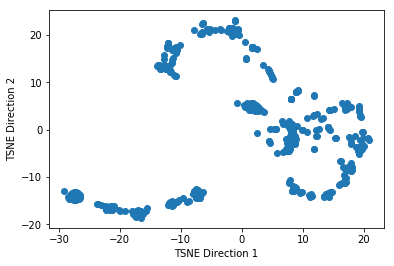

In [26]:
def plot_tsne(tsne):
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.xlabel("TSNE Direction 1")
    plt.ylabel("TSNE Direction 2")

plot_tsne(tsne)
plt.show()

The TSNE plot indicates that certain politicians group together, which manifests in several clusters forming. However, note that the results of the TSNE should be taken with a grain of salt, since its complexity sometimes leads to unexpected results.

## 1.3 Graph Representation
A third way to represent the politicians will be in the form of an undirected graph. The graph is imputed such that every politician is connected to his k nearest neighbors in space. For technical reasons, we want the resulting graph to be connected. Moreover, we will assign as the weight between the two politicians $p_1$ and $p_2$ to be:
$\quad w_{ij} = \exp \{ \frac{1}{2\sigma^2} \|p_1 - p_2\|_2^2 \}$

In [27]:
def get_knn_graph(pc, k=10):
    """
    Obtains knn_graph, returns networkX weighted graph object.
    
    Parameters
    ----------
    pc:
        Principal components for graph imputation
    k:
        Number of nearest neighbors to consider
    """
    knn_graph = kneighbors_graph(pc, k, mode="connectivity")

    # Create networkx object
    nx_graph = nx.from_scipy_sparse_matrix(knn_graph)
    if not nx.is_connected(nx_graph):
        warnings.warn("Resulting graph is not connected, spectral embedding may give unexpected results")
    return nx_graph

knn_graph = get_knn_graph(pc, k=10, sigma=.1)
knn_graph_plot_pos = nx.spring_layout(knn_graph)

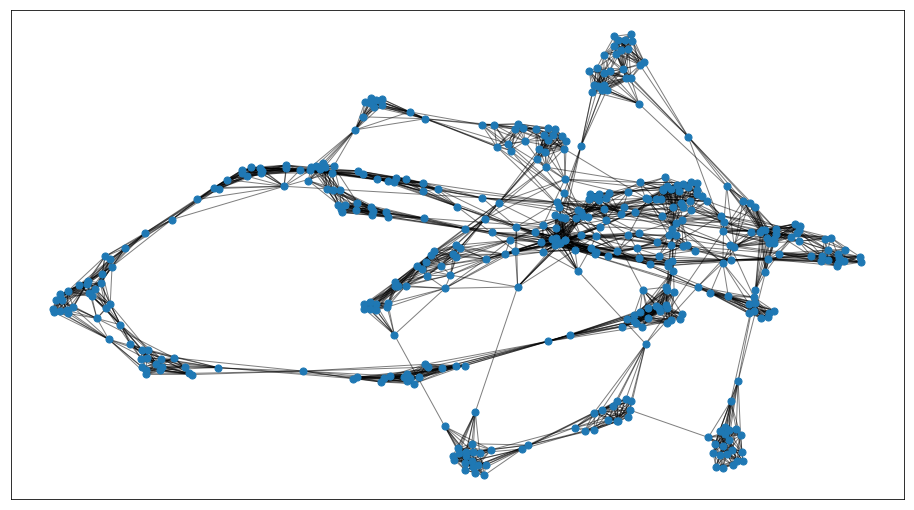

In [28]:
def draw_graph(G, pos=None):
    if pos is None:
        pos=nx.spring_layout(G)
    labels = np.array(list(nx.get_edge_attributes(G,'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=.5)
    
plt.figure(figsize=(16,9))
draw_graph(knn_graph, knn_graph_plot_pos)

**Spectral Embedding**<br>
The spectral embedding embeds the graph into a n-dimensional space. This can be used for visualizing the graph itself or for spectral clustering, as used below. 
<br><br>
Reference:
*U. Von Luxburg*, “A tutorial on spectral clustering,” *Stat. Comput., vol. 17, no. 4, pp. 395–416, 2007.*

In [29]:
def spectral_embedding(nx_graph, n=15):
    """
    Calculates spectral embedding based on normalized Laplacian matrix.
    
    Parameters
    ----------
    nx_graph:
        NetworkX graph to analyze
    n_evals:
        Number of smallest eigenvalues and corresponding eigenvectors to be computed
        
    Returns
    -------
    evals:
        Eigenvalues of spectral embedding
    evecs:
        Eigenvectors of spectral embedding
    """
    norm_L = nx.normalized_laplacian_matrix(nx_graph)
    evals, evecs = eigs(norm_L, k=n, which="SM")
    evals = np.real(evals)
    evecs = np.real(evecs)
    return evals, evecs

sp_evals, sp_evecs = spectral_embedding(knn_graph)

#### Validation
We validate the graph by looking at its properties.


*Node degree distribution*

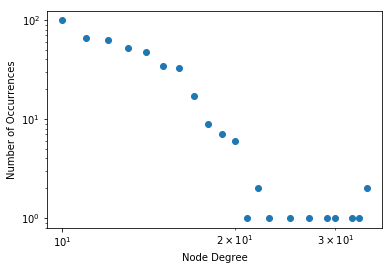

In [30]:
def plot_degree_distribution(graph):
    deg = np.array(graph.degree())[:,1]
    val, count = np.unique(deg, return_counts=True)
    plt.loglog(val, count, 'o')
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Occurrences")
plot_degree_distribution(knn_graph)

Here, we plot the node degree distribution. We see that it is heavy-tailed, roughly follows a power law. This behavior is typical for social networks, which suggests that our graph is an adequate representation for the political landscape.

## 1.4 Saving Intermediary Results

In [40]:
np.save("../generated/politician_pc", pc)
np.save("../generated/politician_tsne", tsne)
with open('../generated/politician_graph.pickle', 'wb') as file:
    pickle.dump(knn_graph, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('../generated/politician_graph_plot_pos.pickle', 'wb') as file:
    pickle.dump(knn_graph_plot_pos, file, protocol=pickle.HIGHEST_PROTOCOL)

# 2. Recovering Clusters

## 2.1 K-Means Clustering

We perform k-means clustering in order to cluster our politicians based on their voting behavior. We do this on the principal components calculated above, in order to avoid the curse of dimensionality.

We run k-means clustering with a range of possible number of clusters. Then, we determine the optimal number of clusters using a so-called knee-plot, which plots the within-cluster variance against the number of clusters. 

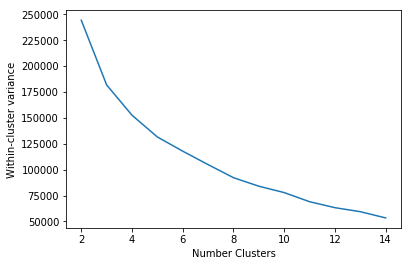

In [41]:
cluster_range = np.arange(2, 15)
kmeans_fit = []
inertia = []
for nc in cluster_range:
    cl = KMeans(n_clusters=nc).fit(pc)
    kmeans_fit.append(cl)
    inertia.append(cl.inertia_)
    
plt.plot(cluster_range, inertia)
plt.ylabel("Within-cluster variance")
plt.xlabel("Number Clusters")
plt.show()

In the knee-plot, the optimal number of clusters can be determined as the "knee" of the graph. In our case, this is somewhat hard to determine, but 6 clusters seem plausible.

In [42]:
ix = np.where(cluster_range==6)[0][0]
kmeans_cl = kmeans_fit[ix].labels_

## 2.2 Graph Based Clustering
In order to validate the clustering, we compare the results with graph-based clustering. For this we impute a graph of politicians as a k-nearest-neighbor graph, where we connect every politician to their k nearest neighbors in the space of the most important principal components. This allows us to perform spectral clustering on the resulting graph.

#### Spectral Clustering
From the spectral decomposition, we can obtain the number of clusters in the graph with the so-called eigengap heuristic: According to it, the number of clusters is given by the value $k$ that maximizes the difference of consecutive eigenvalues.

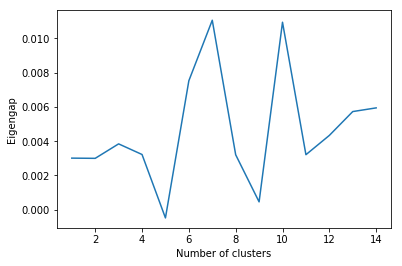

In [43]:
def plot_eigengap(evals):
    n_evals = len(evals)
    
    plt.plot(np.arange(1, n_evals), sp_evals[1:] - sp_evals[:-1])
    plt.xlabel("Number of clusters")
    plt.ylabel("Eigengap")
    plt.show()
    
plot_eigengap(sp_evals)

The plot suggests that $k=7$ or $k=10$ clusters seem to be present within the graph. We determine the cluster assingment as follows: We take the $k$ first dimensions of the spectral embedding and perform k-means clustering in that space.

In [44]:
def spectral_clustering(evecs, k):
    red = evecs[:,:k]
    clusters = KMeans(n_clusters=k).fit_predict(red)
    return clusters

spec_cl_10 = spectral_clustering(sp_evecs, 10)
spec_cl_7 = spectral_clustering(sp_evecs, 7)

## 2.3 Clustering Result Comparison
We now go back to our TSNE plot to visualize the different clusterings we obtained so far.

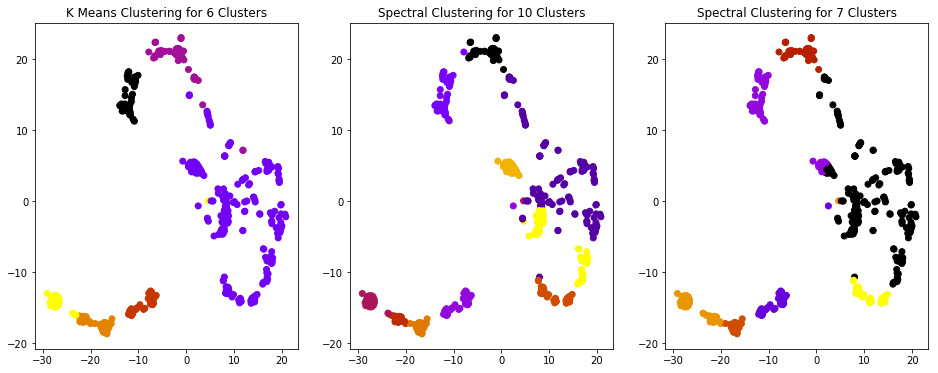

In [45]:
def visualize_clusterings(coordinates, clusters):
    plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters, cmap="gnuplot")
    
plt.figure(figsize=(16,6))

plt.subplot(131)
plt.title("K Means Clustering for 6 Clusters")
visualize_clusterings(tsne, kmeans_cl)

plt.subplot(132)
plt.title("Spectral Clustering for 10 Clusters")
visualize_clusterings(tsne, spec_cl_10)

plt.subplot(133)
plt.title("Spectral Clustering for 7 Clusters")
visualize_clusterings(tsne, spec_cl_7)


We observe that the three clustering procedures seem to cluster similarly. Moreover, the clusters seem to be in accordance to what can visually be identified as clusters on the TSNE plots. This suggests that the clustering is pretty robust, which in turn indicates that politicians seem to form clusters.

# Intermediary Conclusions
What have we learned so far? There are two key conclusions that can be drawn from our analysis so far:
- From the fact that we recover similar clusterings with different clustering methods, we conclude that politicians can be grouped together according to their voting behavior.
- We constructed a graph of all politicians, which has the properties of a social network and from which the clusters can be recovered. This suggests that the graph representation is of good quality, and will provide a useful tool in our future analysis.

# Part 3 : Are political parties essential for choosing the executive federal council?

In [5]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.neighbors import kneighbors_graph

import networkx as nx

from scipy.sparse.linalg import eigs

import data_loading

## Getting the Data

## Finding the Federal conselor
The first step is to find the federal conselor in the votes DataFrame 

> First let's create a DataFrame with all federal conselor and their CouncillorId

In [167]:
federal_conselor = members.loc[members["CouncilName"] == "Conseil fédéral"][['FirstName','LastName']].drop_duplicates()
federal_conselor = federal_conselor.set_index(['FirstName','LastName'])
federal_conselor_votes = full_votes.join(federal_conselor,on=['FirstName','LastName'],how="right")
federal_conselor_votes = federal_conselor_votes[["FirstName","LastName","PartyAbbreviation","CouncillorId"]].groupby("CouncillorId").last()
federal_conselor_votes.index = federal_conselor_votes.index.map(int)
federal_conselor_votes

,FirstName,LastName,PartyAbbreviation
CouncillorId,,,
21,Christoph,Blocher,UDC
146,Ueli,Maurer,UDC
508,Johann N.,Schneider-Ammann,PRD
1108,Guy,Parmelin,UDC
1116,Didier,Burkhalter,PRD
1288,Viola,Amherd,PDC
3828,Ignazio,Cassis,PLR


> Then let's map the concillor id to it's position in the vote dataframe 

 > We see that our analysis will be limited by the fact that only seven politician were voting during the gathering of the data at our disposal and went on to the federal consel. This is too few datapoint to derive some meaningful conclusion but it is still interesting to analyse those points.

In [292]:
CouncillorId_to_idx = dict(zip(votes.T.index.map(int),range(len(votes.T))))
ids_to_CouncillorId = dict(zip(range(len(votes.T)),votes.T.index.map(int)))

In [169]:
federal_conselor_votes["idx"]= list(map(lambda x :CouncillorId_to_idx[int(x)],federal_conselor_votes.index))

> Now let's see where those politicians are in the representation of our data we made above

In [145]:
# Get the pca 
def do_pca(data, explained_var=.75, return_fits=True):
    """
    Rescales variables to have mean zero, then performs PCA.
    
    Parameters
    ----------
    data:
        Data to transform. Rows are observations, columns are features
    explained_var:
        Retains enough principal components to explain "explained_var" percent
        of the total variance
    return_fits:
        If true, returns the rescale fit and the pca fit together with the principal components.
        Otherwise returns only principal components.
    """
    
    # Fit scaler and PCA
    scalefit = StandardScaler(with_std=False).fit(data)
    scaled = scalefit.transform(data)
    pcafit = PCA().fit(scaled)
    
    # Get nb pcs to retain
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    nb_retain = np.where(expl_var>.75)[0][0]
    
    # Project onto PCs
    pc = pcafit.transform(scaled)[:,:nb_retain]
    
    if return_fits:
        return pc, scalefit, pcafit
    else:
        return pc

pc, scalefit, pcafit = do_pca(votes.T.values)

/Users/oriane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/oriane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


> Let's generate a tsne (TODO it would be nice to just use the same as in part 1)

In [332]:
tsne = TSNE().fit_transform(pc)

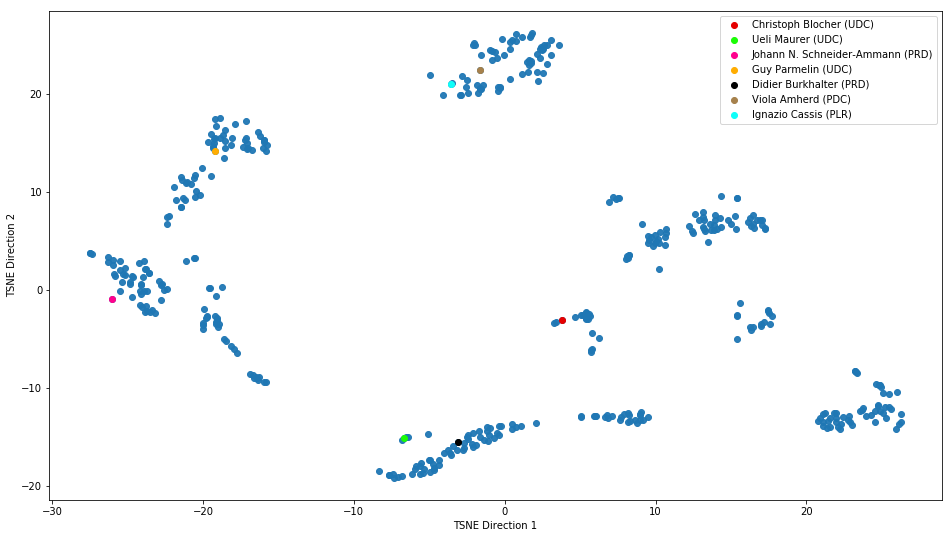

In [333]:
def highlight_nodes_tsne(concelor_df,tsne):
    plt.figure(figsize=(16,9))
    def plot_tsne(tsne):
        plt.scatter(tsne[:,0], tsne[:,1],alpha=0.95)
        plt.xlabel("TSNE Direction 1")
        plt.ylabel("TSNE Direction 2")
    def write_names(first,last,party):
        return first + " " +last + " (" + party + ")"

    plot_tsne(tsne)
    labels = [write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in concelor_df.iterrows()]
    idx = concelor_df["idx"].values
    colors = ['xkcd:red','xkcd:highlighter green','xkcd:hot pink','xkcd:orange yellow','xkcd:black','xkcd:coffee','xkcd:bright turquoise']
    for c,(id_,l) in zip(colors,zip(idx,labels)):
        plt.scatter(tsne[id_,0], tsne[id_,1],label=l,c=c)
    plt.legend()
    plt.show()
highlight_nodes_tsne(federal_conselor_votes,tsne)

> Interestingly all points seem to be quite far appart and members of different "clusters". It is noteworthy that member of same party such as Chrisoph Blocher, Guy Parmelin and Ueli Maurer are so far appart, yet one should be careful when interpreting plot such as this one. We can now try and visualizing them on the graph representation.

In [170]:
def get_knn_graph(pc, k=10, sigma=1):
    """
    Obtains knn_graph, returns networkX weighted graph object, where the weights are the 
    graph distance.
    
    Parameters
    ----------
    pc:
        Principal components for graph imputation
    k:
        Number of nearest neighbors to consider
    sigma:
        The variance of the distance kernel
    """
    knn_graph = kneighbors_graph(pc, k, mode="distance")
    
    # Calculate kernel on non-zero elements of sparse matrix
    np.exp( -knn_graph.data / 2*sigma**2, out=knn_graph.data )

    # Create networkx object
    nx_graph = nx.from_scipy_sparse_matrix(knn_graph, edge_attribute='weight')
    if not nx.is_connected(nx_graph):
        warnings.warn("Resulting graph is not connected, spectral embedding may give unexpected results")
    return nx_graph

knn_graph = get_knn_graph(pc, k=10, sigma=.1)


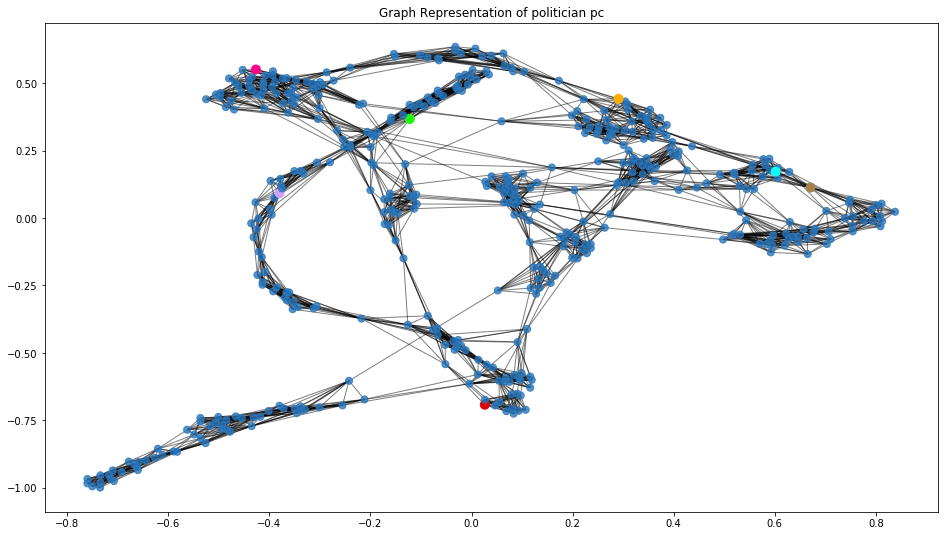

In [316]:
#Plotting the graph
def highlight_nodes_network(concelor_df):
    plt.figure(figsize=(16,9))
    G = knn_graph

    ## assign a node attribute
    federal_conselor_dict = {x["idx"] : write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in concelor_df.iterrows()}
    federal_conselor_dict[0] = "Some rando"


    for node in G.nodes():
        G.node[node]['federal_conselor'] = federal_conselor_dict.get(node, "Some rando")

     ## Create list of plotting attributes 
    labels = [write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in concelor_df.iterrows()]
    idx = federal_conselor_votes["idx"].values
    colors = ['xkcd:red','xkcd:highlighter green','xkcd:hot pink','xkcd:orange yellow','xkcd:lilac','xkcd:coffee','xkcd:bright turquoise']
    color_map = {name : color for name,color in zip(labels,colors)} 
    color_map["Some rando"] = "xkcd:bluish"
    alpha_map = {name : 1 for name in labels}
    alpha_map["Some rando"] = .8
    size_map = {name :80 for name in labels } 
    size_map["Some rando"] = 50 

    nodes_colors = [color_map[G.node[node]['federal_conselor']] for node in G]
    nodes_sizes = [size_map[G.node[node]['federal_conselor']] for node in G]
    nodes_alphas = [alpha_map[G.node[node]['federal_conselor']] for node in G]
    ## plotting the graph with given atttributes
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos, node_color=nodes_colors,node_size=nodes_sizes,alpha=nodes_alphas)
    nx.draw_networkx_edges(G, pos, alpha=.5)

    plt.title("Graph Representation of politician pc")
    plt.show()
    
highlight_nodes_network(federal_conselor_votes)

> Again they all seem quite well dispersed. It also interesting to note that all points seems somehow well connected. It would seems like a good criteria for a exectutive represent to be a "hub" of the graph as it would mean they are ?? with more people. Let's take a closer look at the "hub" propriety of our three conselor.

Christoph Blocher (UDC) 10
Ueli Maurer (UDC) 14
Johann N. Schneider-Ammann (PRD) 10
Guy Parmelin (UDC) 11
Didier Burkhalter (PRD) 16
Viola Amherd (PDC) 17
Ignazio Cassis (PLR) 11


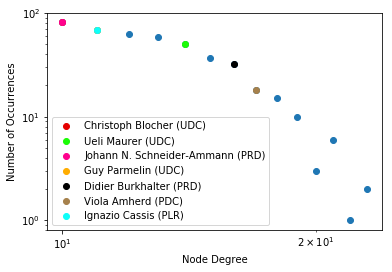

In [220]:
def plot_degree_distribution(graph):
    deg = np.array(graph.degree())[:,1]
    val, count = np.unique(deg, return_counts=True)
    dict_hist = dict(zip(val, count))
    plt.loglog(val, count, 'o')
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Occurrences")
    for c,(id,l) in zip(colors,zip(federal_conselor_votes["idx"],labels)) :
        val = graph.degree(id)
        print(l,val)
        plt.loglog(val,dict_hist[val], 'o',label = l,c=c)
    plt.legend()
plot_degree_distribution(knn_graph)    

> Some of them are somewhat well connected such as Viola Amherd or Dider Burkhalter. But most are not. Rationally it would seem that the most connected a point is, the most people it is agreeing with. We can make the hypothesis that a good executive power is someone who agrees with the most people in the legislative power. This make sense if we want the law maker to be happy with the way their law is applied. Here the process of election is complicated and not based on any defined criteria. The result seem to be quite isolated individual not representative of a majority. It would be interesting to see how well placed (how centered) they are in their own party (TODO). 
NB: Some point are not visible because they overlap with others, this is why we also printed out the degrees.

## Picking our own executive power

> If we still follow the hypothesis that a well connected individual is a good fit for a federal concellor, we can try and derive the best fit from the data. We can make the additional hypothesis that the set of 7 conselor need to cover the full spectrum of political view in the national concil. To do so we use the spectral clustering from part one to create 7 cluster and select the most connected node from each.

In [224]:
def spectral_embedding(nx_graph, n=15):
    """
    Calculates spectral embedding based on normalized Laplacian matrix.
    
    Parameters
    ----------
    nx_graph:
        NetworkX graph to analyze
    n_evals:
        Number of smallest eigenvalues and corresponding eigenvectors to be computed
        
    Returns
    -------
    evals:
        Eigenvalues of spectral embedding
    evecs:
        Eigenvectors of spectral embedding
    """
    norm_L = nx.normalized_laplacian_matrix(nx_graph)
    evals, evecs = eigs(norm_L, k=n, which="SM")
    evals = np.real(evals)
    evecs = np.real(evecs)
    return evals, evecs

sp_evals, sp_evecs = spectral_embedding(knn_graph)

In [226]:
def spectral_clustering(evecs, k):
    red = evecs[:,:k]
    clusters = KMeans(n_clusters=k).fit_predict(red)
    return clusters
spec_cl_7 = spectral_clustering(sp_evecs, 7)

In [286]:
clusters = pd.DataFrame({"Nodes":G.nodes(),"Clusters":spec_cl_7,"Degree":[G.degree(n) for n in G.nodes()]})
clusters = clusters.set_index("Clusters")
# Here we pick for each degree the latest node which gives us the most recent concelor
max_per_clusters = clusters.groupby(["Clusters","Degree"]).last().groupby("Clusters").last()

> Let's see who those concelor are

In [309]:
councillorids = [ids_to_CouncillorId[x["Nodes"]] for i,x in max_per_clusters.iterrows() ]
better_conselor_df = full_votes.loc[full_votes["CouncillorId"].isin(councillorids)]
better_conselor_df = better_conselor_df[["FirstName","LastName","PartyAbbreviation","CouncillorId"]].drop_duplicates(["FirstName","LastName"])
better_conselor_df = better_conselor_df.set_index("CouncillorId")
better_conselor_df["idx"] = list(map(lambda x : CouncillorId_to_idx[x] ,better_conselor_df.index))

In [345]:
better_conselor_df

,FirstName,LastName,PartyAbbreviation,idx
CouncillorId,,,,
1343,Urs,Hany,PDC,204
3888,Hugues,Hiltpold,PRD,235
1141,Philipp,Müller,PRD,172
198,Walter,Schmied,UDC,21
4096,Alois,Gmür,PDC,325
4181,Andrea,Gmür-Schönenberger,PDC,398
4219,Brigitte,Crottaz,PSS,430


> Several observation can already be made : 
- There is no overlapping with the actual list of federal concelor 
- The whole political spectrum is represented  
- The Center is overrepresented 

(TODO, if we did a new way to break up polictical party, is it representative of this new way). Based on this spectrum from "Le Temps" 

NB: the PDR can be assimilated to the PLR

TODO: get local copy of image or use this line to vagly do our own spectrum

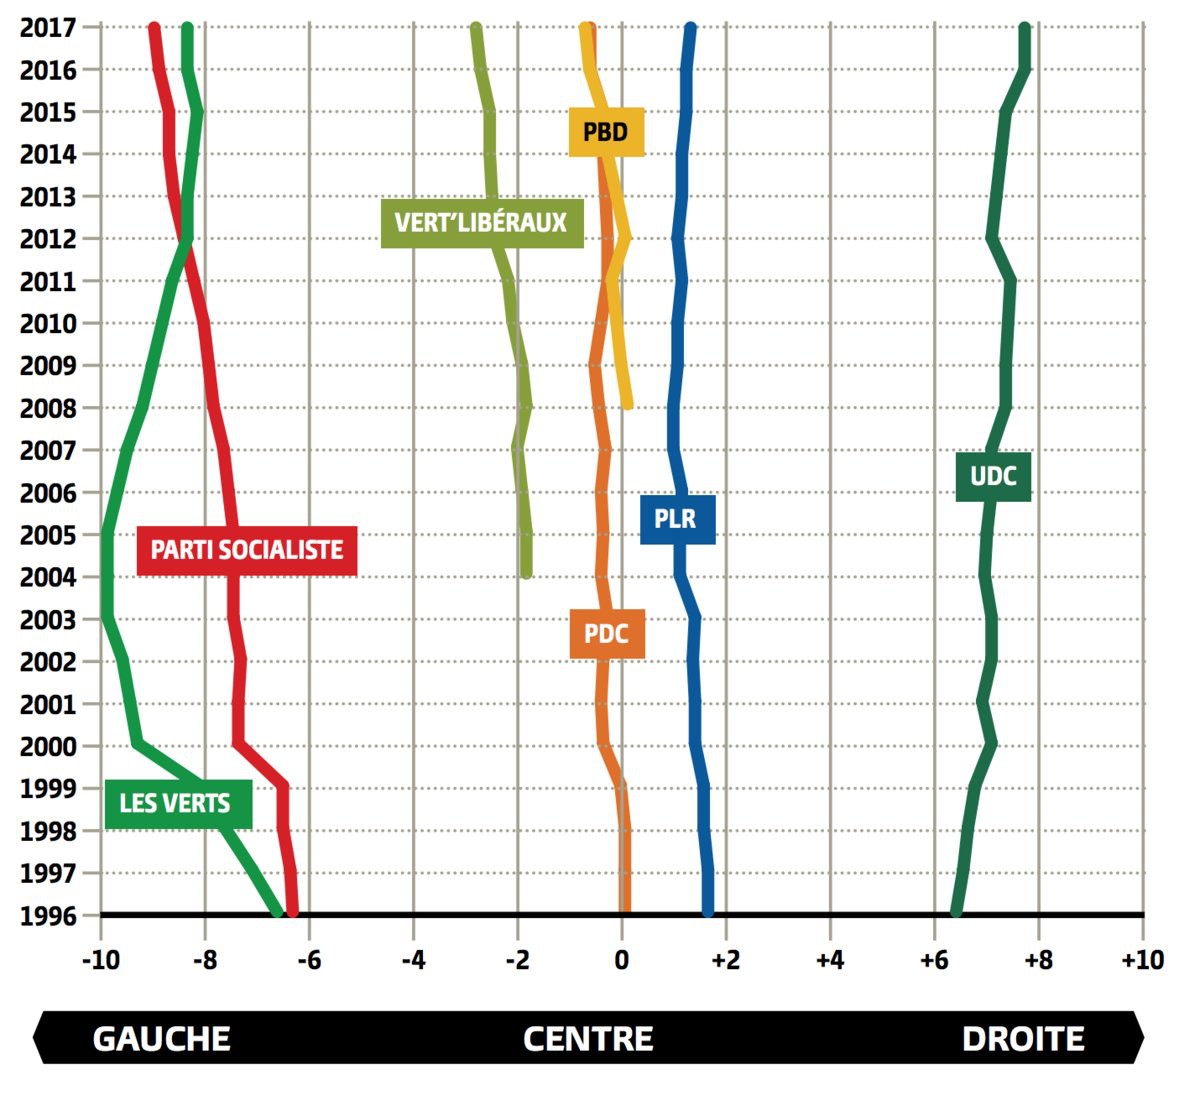

In [347]:
from PIL import Image
from io import BytesIO
import requests
url = "https://assets.letemps.ch/sites/default/files/styles/share/public/media/2017/12/07/file6xvmqbr36s4soxt5kjm.png.jpeg?itok=UHqSuRlU"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

> Let's see on the graph where they would be 

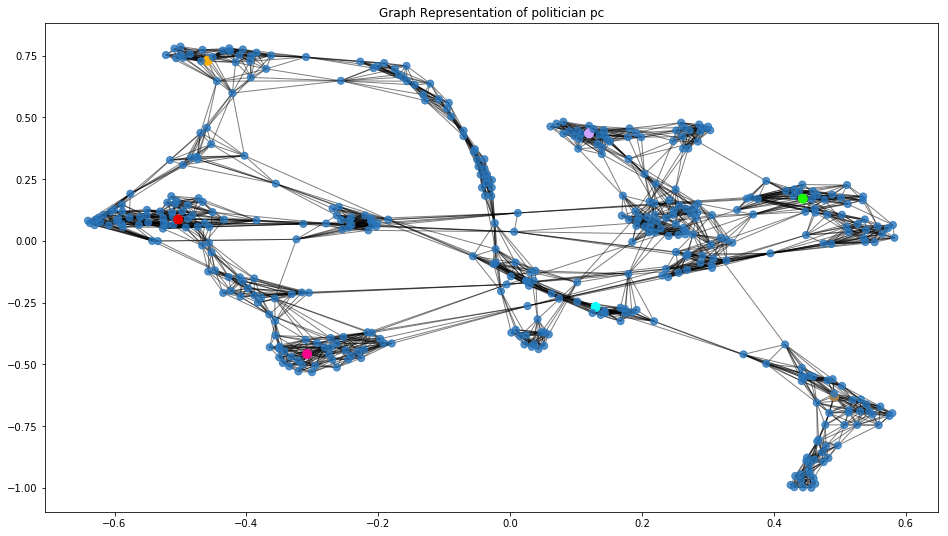

In [317]:
highlight_nodes_network(better_conselor_df)

> We see that they are nicely at the centers of different "clusters" on the graph and span over all major centers.

> Let's vizualise them on the tsne

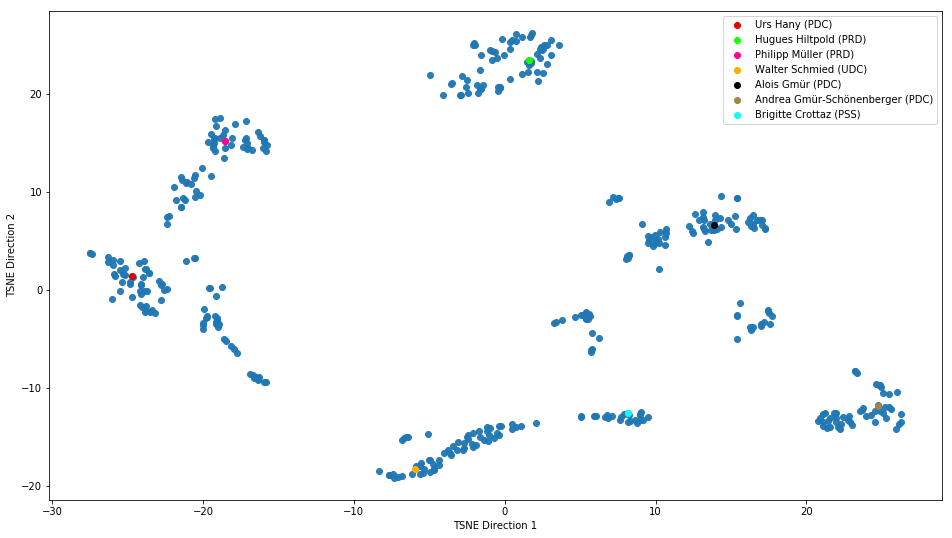

In [334]:
highlight_nodes_tsne(better_conselor_df,tsne)

> Again we see that it is nicely distributed and in the center of each cluster

In [341]:
def visualize_clusterings(coordinates, clusters):
    plt.figure(figsize=(16,9))
    plt.title("K Means Clustering with 7 hubs as seeds")
    plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters, cmap="gnuplot")

/Users/oriane/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


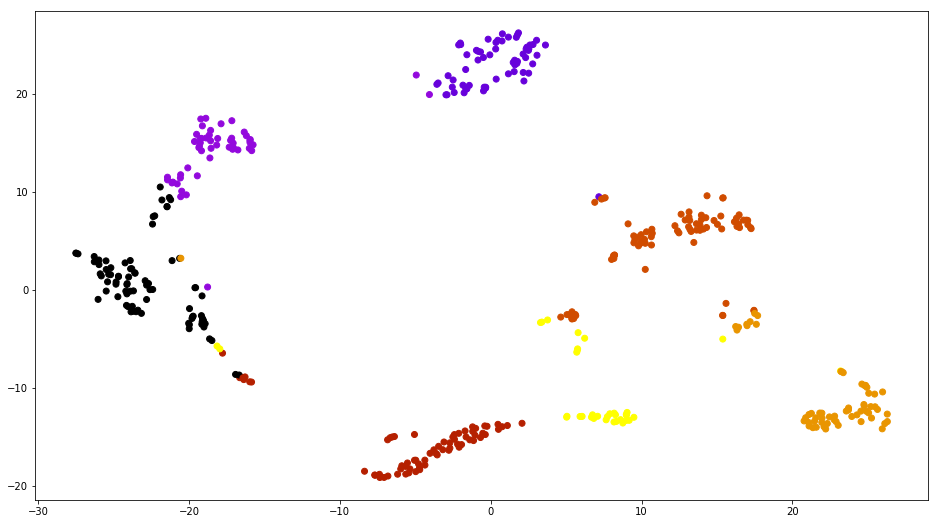

In [344]:
seeds = np.asarray([pc[x["idx"],:] for i,x in better_conselor_df.iterrows() ])
cl = KMeans(n_clusters=7,init=seeds).fit(pc)
visualize_clusterings(tsne, cl.labels_)

> It therefore seems that our pick of federal concelor is good under our two hypotesis. Except for some outliers (such as the fews yellow points in a otherwise black cluster), if we map the representation of our 7 conselor over the legislative power, it seems that everyone would be a could representent for a subgroup. It could be said that here some are representative or fewer members than others.

TODO : 
    - See who this people are
    - See them on the graph
    - see them on the TSNE
    - try doing k-means with them as seeds
    

I still want to see them in the context of their party(for the real and fake ones). Or to try and generate a seed for each of them and see how well it conincid with their party. I also want to see how well the new one would fit in our own made party 